# Statistical analysis

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

datafilename = "data_processed.csv"
d = pd.read_csv(datafilename, index_col=0)
#d = d[-72:] # use just the data for the  last participant

print("Loading", len(d), "lines.")

# ------------------------------------------------------
# functions to calculate AUC and plot ROC

def cummulative(x):
    return [sum(x[0:i+1]) for i in range(len(x))]

def get_auc(x, y):
    # make cummulative
    x, y = cummulative(x), cummulative(y)
    # normalize
    x = [xi/max(x) for xi in x]
    y = [yi/max(y) for yi in y]
    auc = 0
    x1, y1 = 0, 0
    for x2, y2 in zip(x, y):
        auc += (x2 - x1) * (y1 + y2) / 2
        x1, y1 = x2, y2
    return auc

def plot_roc(x, y):
    x, y = cummulative(x), cummulative(y)
    plt.plot((min(x), max(x)), (min(y), max(y)), color='red', linewidth=1, linestyle='--')
    for i in range(len(x)-1):
        plt.plot((x[i], x[i+1]), (y[i], y[i+1]), color='black', linewidth=1)
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker='o', s=30, color='black')
    #plt.xlim(0.0, 1.0)
    #plt.ylim(0.0, 1.0)
    plt.show()

Loading 14544 lines.


## Participants

In [2]:
TPP = 72  # there are 72 trials per participant
TPT = 36  # there are 36 trials per test
TPL = 20  # there are 20 trials per lexical test

for sid in [1, 2]:
    dt = d[d["StudyID"] == sid]
    if not dt.empty:
        print()
        print()
        print("## Counts for study ID:", sid)
        print()
        print("Number of participants:")
        print(len(dt) / TPP) 
        print()
        print("Fluent vs. non-fluent:")
        display(pd.DataFrame(dt["Fluent"].value_counts() / TPP))
        print()
        print("Different kinds of designers and which font was first:")
        
        dtt = pd.DataFrame(columns=["Designer", "Non-designer", "total"], index=["sansforgetica", "arial", "total"])
        dtt["Designer"] = dt[(dt["TestID"] == 1) & (dt["Type"] == "lexical") & (dt["Training"] != "Non-designer")]["Font"].value_counts()
        dtt["Non-designer"] = dt[(dt["TestID"] == 1) & (dt["Type"] == "lexical") & (dt["Training"] == "Non-designer")]["Font"].value_counts()
        dtt /=  TPL
        dtt["total"] = dtt.T.sum()
        dtt.loc["total"] = dtt.sum()
        display(dtt)
        print()
        display(pd.DataFrame(dt["Training"].value_counts() / TPP))

        print("JoM for categories of training:")
        display(pd.DataFrame(dt.groupby("Training")["JoM"].mean()))
        print()
        print("JoL for categories of training:")
        display(pd.DataFrame(dt.groupby("Training")["JoL"].value_counts() / TPT))





## Counts for study ID: 1

Number of participants:
97.0

Fluent vs. non-fluent:


,Fluent
True,89.0
False,8.0



Different kinds of designers and which font was first:


,Designer,Non-designer,total
sansforgetica,26.0,21.0,47.0
arial,27.0,23.0,50.0
total,53.0,44.0,97.0


,Training
Non-designer,44.0
Letter designer,25.0
Graphic designer,17.0
Other designer,6.0
Typographer,5.0


JoM for categories of training:


,JoM
Training,
Graphic designer,56.735294
Letter designer,55.160000
Non-designer,53.977273
Other designer,49.166667
Typographer,61.000000



JoL for categories of training:


JoL
Training         JoL                         
Graphic designer very easy to read       13.0
                 ok                      10.0
                 easy to read             5.0
                 difficult to read        4.0
                 very difficult to read   2.0
Letter designer  very easy to read       14.0
                 difficult to read       13.0
                 ok                      11.0
                 easy to read             9.0
                 very difficult to read   3.0
Non-designer     very easy to read       38.0
                 ok                      22.0
                 difficult to read       14.0
                 easy to read            12.0
                 very difficult to read   2.0
Other designer   very easy to read        5.0
                 ok                       4.0
                 difficult to read        2.0
                 very difficult to read   1.0
Typographer      very easy to read        4.0
                 difficult to read        3.0
                 ok                       2.0
                 easy to read             1.0



## Counts for study ID: 2

Number of participants:
105.0

Fluent vs. non-fluent:


,Fluent
True,90.0
False,15.0



Different kinds of designers and which font was first:


,Designer,Non-designer,total
sansforgetica,31.0,23.0,54.0
arial,28.0,23.0,51.0
total,59.0,46.0,105.0


,Training
Non-designer,46.0
Graphic designer,25.0
Letter designer,15.0
Other designer,12.0
Typographer,7.0


JoM for categories of training:


,JoM
Training,
Graphic designer,52.240000
Letter designer,58.366667
Non-designer,51.369565
Other designer,53.083333
Typographer,59.000000



JoL for categories of training:


JoL
Training         JoL                         
Graphic designer very easy to read       21.0
                 difficult to read       11.0
                 easy to read             9.0
                 ok                       9.0
Letter designer  difficult to read       12.0
                 easy to read             7.0
                 very easy to read        6.0
                 ok                       4.0
                 very difficult to read   1.0
Non-designer     very easy to read       40.0
                 ok                      20.0
                 difficult to read       15.0
                 easy to read            11.0
                 very difficult to read   6.0
Other designer   very easy to read        8.0
                 difficult to read        6.0
                 easy to read             5.0
                 ok                       4.0
                 very difficult to read   1.0
Typographer      ok                       6.0
                 very easy to read        5.0
                 easy to read             3.0

## Calculating AUC and RT

In [7]:

map_JoL = {
    "very easy to read": 100,
    "easy to read": 75,
    "ok": 50,
    "difficult to read": 25,
    "very difficult to read": 0,
}

def get_agg_results(d):
    """
    Aggregate data for every (study, test, participant) combination.
    Calculate AUC and RT across all of their relevant responses
    (originally 36 trials, but could be less after outliers were removed)
    and average them for: all, words,  and non-words.
    """

    # prepare empty results DataFrame
    # aggregate correct and response time (use mean value)
    # the rest is either copied or new (NaN value)
    result_columns = ["StudyID", "ParticipantID", "TestID", "Type", "Order", "Firstfont",
                      "Fluent", "Training", "isDesigner", "Font", "Correct", "RT",
                      "RT_word", "RT_nonword",
                      "AUC", "AUC_word", "AUC_nonword",
                      "JoL", "JoM", "Date"]
    agg_columns = {k:"first" for k in set(d.columns).intersection(result_columns)}
    agg_columns["Correct"] = "mean"
    agg_columns["RT"] = "mean"
    results = d.groupby(["StudyID", "ParticipantID", "TestID", "Type"]).agg(agg_columns)
    results = pd.DataFrame(results, columns=result_columns)
    results.set_index(["StudyID", "ParticipantID", "TestID", "Type"], inplace=True)
    results["isDesigner"] = results["Training"] != "Non-designer" # to conveniently group designers together
    for k, v in map_JoL.items():
        results["JoL"] = results["JoL"].astype(str).replace(k, v)
    results["JoL"] = results["JoL"].astype(float)

    test_ids = set(d["TestID"].unique())
    
    # prepare indexes for temporary data frames
    # there are two, one based on the Category column used for lexical tasks
    # and one based on the Seen column used for recognition
    ix = {}
    category_used = "Category"
    categories = ["word", "non-word"]
    responses = ["Sure word", "Probably word", "Probably non-word", "Sure non-word"]
    ix["lexical"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))
    category_used = "Seen"
    categories = ["seen", "not seen"]
    responses = ["Sure seen", "Probably seen", "Probably not seen", "Sure not seen"]
    ix["recognition"] = (category_used, pd.MultiIndex.from_product([categories, responses], names=[category_used, "Response"]))

    # loop across study IDs, participant IDs, Test IDs, and Test types
    # to get each part separately
    for sid in d["StudyID"].unique():
        for pid in d[d["StudyID"] == sid]["ParticipantID"].unique():
            for tid in test_ids:
                for order, ttype in enumerate(sorted(dt["Type"].unique())):
                    # focus the data frame
                    dtt = d[(d["StudyID"] == sid) & (d["ParticipantID"] == pid) & (d["TestID"] == tid) & (d["Type"] == ttype)]
                    # figure out which category and index to use for this Test type
                    category_used, index = ix[ttype]
                    # get/save the order of tests
                    if sid == 1:
                        # in study #1 it corresponds to 1 = lexical, 2 = recognition
                        results.loc[(sid, pid, tid, ttype), "Order"] = [1, 2][order]
                    else:
                        # in study #2 it depends on the Test ID
                        if tid == 1:
                            results.loc[(sid, pid, tid, ttype), "Order"] = [1, 2][order]
                        elif tid == 2:
                            results.loc[(sid, pid, tid, ttype), "Order"] = [2, 1][order]
                    # to calculate the AUC, get response frequencies for each test type first
                    # ensure the order in the index is always the same
                    dg = pd.DataFrame(index=index)
                    dg["Frequencies"] = dtt.groupby([category_used])["Response"].value_counts()
                    dg = dg.fillna(0)
                    # calculate the AUC
                    # use frequencies for word/seen for the y coordinate
                    # use frequencies for non-word/not seen for the x coordinate
                    freqs = dg["Frequencies"].tolist()
                    auc = get_auc(freqs[4:], freqs[:4])
                    results.loc[(sid, pid, tid, ttype), "AUC"] = auc
                    # get the overall mean RT
                    rt = dtt["RT"].mean()
                    results.loc[(sid, pid, tid, ttype), "RT"] = rt
                    # get the mean AUC and RT for words and non-words
                    for cat in ["word", "non-word"]:
                        cat_ = cat.replace("-", "")
                        if ttype == "recognition":
                            dg["Frequencies"] = dtt[dtt["Category"] == cat].groupby([category_used])["Response"].value_counts()
                            dg = dg.fillna(0)
                            freqs = dg["Frequencies"].tolist()
                            auc = get_auc(freqs[4:], freqs[:4])
                            results.loc[(sid, pid, tid, ttype), "AUC_%s" % cat_] = auc
                        rt = dtt[dtt["Category"] == cat]["RT"].mean()
                        results.loc[(sid, pid, tid, ttype), "RT_%s" % cat_] = rt
            results.loc[(sid, pid), "Firstfont"] = results.loc[(sid, pid, 1, "lexical"), "Font"]
    # fix the type for order column
    results["Order"] = results["Order"].astype(int)
    # swap recognition tests for SID == 2
    # to have lexical and recognition next to each other
    for pid in d[d["StudyID"] == 2]["ParticipantID"].unique():
        backup = results.loc[(2, pid, 1, "recognition")].copy()
        results.loc[(2, pid, 1, "recognition")] = results.loc[(2, pid, 2, "recognition")]
        results.loc[(2, pid, 2, "recognition")] = backup
      
    return results

results = get_agg_results(d)
display(results[-4:])
results.to_csv(datafilename.replace("_processed.csv", "_stats.csv"))

Order Firstfont  Fluent  \
StudyID ParticipantID TestID Type                                   
2       14472         1      lexical          1     arial    True   
                             recognition      1     arial    True   
                      2      lexical          2     arial    True   
                             recognition      2     arial    True   

                                              Training  isDesigner  \
StudyID ParticipantID TestID Type                                    
2       14472         1      lexical      Non-designer       False   
                             recognition  Non-designer       False   
                      2      lexical      Non-designer       False   
                             recognition  Non-designer       False   

                                                   Font  Correct        RT  \
StudyID ParticipantID TestID Type                                            
2       14472         1      lexical              arial   0.9500  2817.600   
                             recognition          arial   0.5625  2763.000   
                      2      lexical      sansforgetica   1.0000  2655.300   
                             recognition  sansforgetica   0.7500  3352.125   

                                           RT_word  RT_nonword       AUC  \
StudyID ParticipantID TestID Type                                          
2       14472         1      lexical      2083.300    3551.900  1.000000   
                             recognition  2567.125    2958.875  0.648438   
                      2      lexical      1993.700    3316.900  1.000000   
                             recognition  3185.250    3519.000  0.812500   

                                          AUC_word  AUC_nonword   JoL  JoM  \
StudyID ParticipantID TestID Type                                            
2       14472         1      lexical           NaN          NaN  75.0   50   
                             recognition   0.65625      0.71875  25.0   46   
                      2      lexical           NaN          NaN  25.0   46   
                             recognition   0.93750      0.75000  75.0   50   

                                                      Date  
StudyID ParticipantID TestID Type                           
2       14472         1      lexical      12-04-2019 09:34  
                             recognition  12-04-2019 09:34  
                      2      lexical      12-04-2019 09:34  
                             recognition  12-04-2019 09:34

In [9]:
def remove_outliers(d):
    lexical_mean = d[d["Type"] == "lexical"]["RT"].mean()
    lexical_sem = d[d["Type"] == "lexical"]["RT"].std()
    recognition_mean = d[d["Type"] == "recognition"]["RT"].mean()
    recognition_sem = d[d["Type"] == "recognition"]["RT"].std()
    
    mask = []
    for i, r in d.iterrows():
        if r["Type"] == "lexical":
            mask.append(np.abs(r["RT"] - lexical_mean) <= 2 * lexical_sem)
        else:
            mask.append(np.abs(r["RT"] - recognition_mean) <= 2 * recognition_sem)
    
    return d[mask].copy()

#dwo = d[np.abs(d["RT"] - d["RT"].mean()) <= 3 * d["RT"].sem()].copy()

dwo = remove_outliers(d)

# get the aggregated results (AUCs & RTs)
resultswo = get_agg_results(dwo)

# sanity check
dwort = dwo["RT"].dropna()
print("From %d original responses, %d outliers removed, resulting total is %d." % (len(d), len(d) - len(dwort), len(dwort)))
print()
print("Original mean RT: %.3f (%.3f SEM, %.3f STD)" % (d["RT"].mean(), d["RT"].sem(), d["RT"].std()))
print("     New mean RT: %.3f (%.3f SEM, %.3f STD)" % (dwo["RT"].mean(), dwo["RT"].sem(), dwo["RT"].std()))

dwo.to_csv(datafilename.replace("_processed.csv", "_processed-without-outliers.csv"))
resultswo.to_csv(datafilename.replace("_processed.csv", "_stats-without-outliers.csv"))

From 14544 original responses, 24 outliers removed, resulting total is 14520.

Original mean RT: 4092.823 (1253.648 SEM, 151188.117 STD)
     New mean RT: 2735.237 (17.155 SEM, 2067.148 STD)


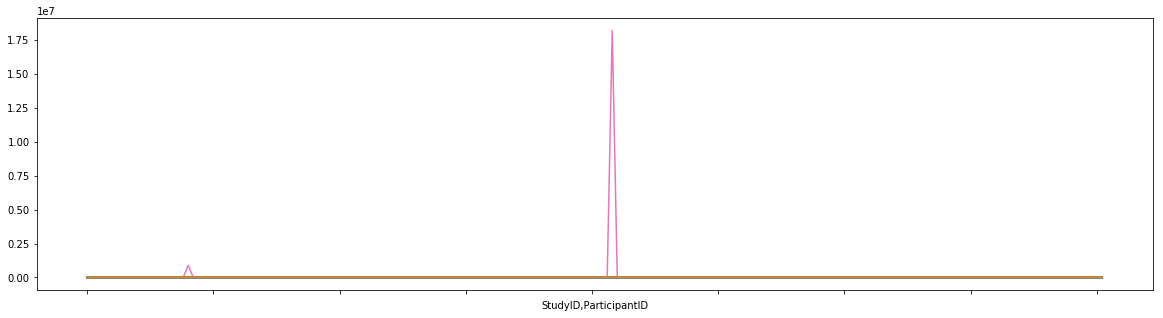

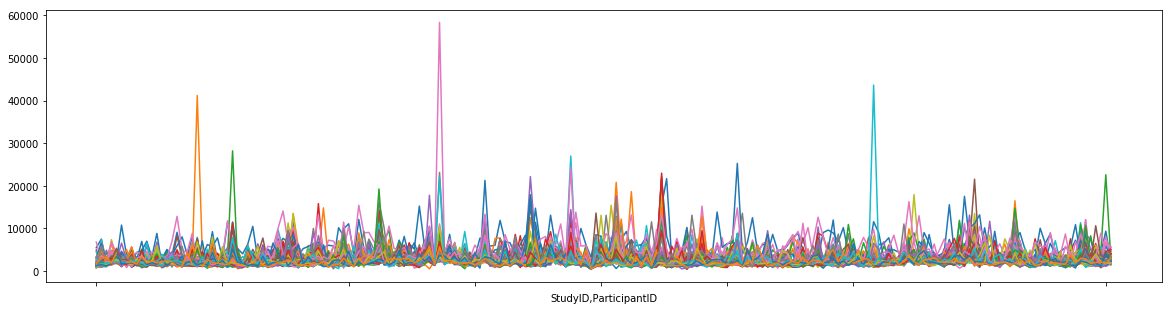

In [10]:
def plot_times(d):
    times = pd.DataFrame(d, columns=["ix", "StudyID", "ParticipantID", "TestID", "Type", "RT"])
    times["ix"] = times.groupby(["StudyID", "ParticipantID"]).cumcount()
    del times["TestID"]
    del times["Type"]
    times.set_index(["StudyID", "ParticipantID", "ix"], inplace=True)
    times = times.unstack("ix")
    times.plot(figsize=(20, 5), legend=False)

# plot times for all responses incl. outliers

plot_times(d)

# plot times for all responses without outliers

plot_times(dwo)

